In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from keras.metrics import MeanAbsoluteError, RootMeanSquaredError, mean_squared_error
from sklearn.metrics import r2_score
from keras.regularizers import l1

import warnings
warnings.filterwarnings('ignore')

### 1. Import Dataset

In [2]:
df = pd.read_csv("historical_sectors.csv", low_memory=False)

df.dropna(axis=0, inplace=True)
df.head(5000)

,DATE,XLE_CLOSE,XLE_VOL,XLE_SMA_200,XLE_EMA_100,XLE_MACD,XLE_RSI,XLE_CCI,XLE_STOCH,XLE_LBB,...,CPIENGSL,H8B1058NCBCMG,TOTALSA,JTSJOL,MEDIAN_CPI,TB3SMFFM,T10YIEM,EXPINF2YR,CSUSHPINSA,UMCSENT
0,1/3/2006,31.9065,24190200,28.2759,29.9028,0.1311,60.2638,69.0318,43.9043,29.4094,...,196.60,9.0,18.08,4397,2.88,-0.05,2.41,2.43,180.83,91.2
1,1/4/2006,31.9973,19997900,28.3056,29.9443,0.2062,60.9163,122.0506,70.3419,29.5759,...,196.60,9.0,18.08,4397,2.88,-0.05,2.41,2.43,180.83,91.2
2,1/5/2006,31.5916,23561000,28.3349,29.9769,0.2304,56.4563,96.3993,88.0642,29.8227,...,196.60,9.0,18.08,4397,2.88,-0.05,2.41,2.43,180.83,91.2
3,1/6/2006,32.3666,18145900,28.3705,30.0242,0.3085,62.1567,170.0392,90.1963,30.3621,...,196.60,9.0,18.08,4397,2.88,-0.05,2.41,2.43,180.83,91.2
4,1/9/2006,32.3302,15235200,28.4060,30.0699,0.3633,61.7485,139.5576,88.8662,31.4646,...,196.60,9.0,18.08,4397,2.88,-0.05,2.41,2.43,180.83,91.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4336,3/27/2023,78.8554,20111900,79.9468,82.6998,-1.9117,44.6214,-8.2366,32.8621,76.0724,...,280.96,-16.8,15.40,9745,4.91,0.04,2.30,2.20,297.14,62.0
4337,3/28/2023,80.0747,16298400,79.9186,82.6478,-1.6587,48.2975,42.2167,43.0645,75.9071,...,280.96,-16.8,15.40,9745,4.91,0.04,2.30,2.20,297.14,62.0
4338,3/29/2023,81.1849,18102300,79.9032,82.6188,-1.3530,51.4573,104.3136,59.3835,75.5739,...,280.96,-16.8,15.40,9745,4.91,0.04,2.30,2.20,297.14,62.0
4339,3/30/2023,81.5418,13730400,79.9115,82.5975,-1.0697,52.4629,129.1317,75.9825,76.5954,...,280.96,-16.8,15.40,9745,4.91,0.04,2.30,2.20,297.14,62.0


In [3]:
# Convert the date column to datetime
df['DATE'] = pd.to_datetime(df['DATE'])

# Set the date column as the index
df.set_index('DATE', inplace=True)

###
### 2.  Data Partitioning

In [4]:
# Split features and targets
X = df.drop(['XLE_CLOSE', 'XLB_CLOSE', 'XLP_CLOSE', 'XLV_CLOSE', 'XLF_CLOSE', 
             'SMH_CLOSE','XLU_CLOSE', 'IYR_CLOSE', 'VOX_CLOSE', 'XLI_CLOSE', 
             'XLY_CLOSE'],axis=1)

y = df[['XLE_CLOSE', 'XLB_CLOSE','XLP_CLOSE', 'XLV_CLOSE', 'XLF_CLOSE', 
             'SMH_CLOSE','XLU_CLOSE', 'IYR_CLOSE', 'VOX_CLOSE', 'XLI_CLOSE', 
             'XLY_CLOSE']]

In [5]:
#Test-Train Splits

# Test and train+validation sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, 
                                                            test_size=0.2, 
                                                            random_state=42, shuffle=False)

#Train and Validation Sets Split
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, 
                                                  test_size=0.25, #Validation set becomes 25% of training set
                                                  random_state=42, shuffle=False)

In [6]:
# Scale features
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

y_train_scaled = scaler.fit_transform(X_train)


###
### 3.  PCA Dimensionality Reduction

In [7]:
#Perform PCA
n_components = 10
pca = PCA(n_components)

X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca = pca.transform(X_val_scaled)
X_test_pca = pca.transform(X_test_scaled)

In [8]:
#Variance Ratio for the 10 Component PCA
var_pca = pca.explained_variance_ratio_
print(var_pca) 

total_var = sum(var_pca)
print("% Variance explained by PCA components:", total_var)

[0.39187942 0.18388179 0.11282355 0.0477636  0.03515677 0.02634234
 0.01961976 0.01567435 0.01543059 0.01154853]
% Variance explained by PCA components: 0.8601207032108091


In [9]:
X_train_pca.shape

(2604, 10)

###
### 4. NN Model Training

#### Data Reshaping

In [10]:
#Features
timesteps = 30
features = 10

X_train_sequences = len(X_train_pca) - timesteps + 1
X_test_sequences = len(X_test_pca) - timesteps + 1
X_val_sequences = len(X_val_pca) - timesteps + 1

X_train_lstm = np.zeros((X_train_sequences, timesteps, features))
X_test_lstm = np.zeros((X_test_sequences, timesteps, features))
X_val_lstm = np.zeros((X_val_sequences, timesteps, features))

for i in range(X_train_sequences):
    X_train_lstm[i] = X_train_pca[i:i + timesteps]
print("Train Set Shape (X):", X_train_lstm.shape)
    
for i in range(X_test_sequences):
    X_test_lstm[i] = X_test_pca[i:i + timesteps]
print("Test Set Shape (X):", X_test_lstm.shape)
    
for i in range(X_val_sequences):
    X_val_lstm[i] = X_val_pca[i:i + timesteps]
print("Validation Set Shape (X):", X_val_lstm.shape)


Train Set Shape (X): (2575, 30, 10)
Test Set Shape (X): (840, 30, 10)
Validation Set Shape (X): (839, 30, 10)


In [11]:
#Targets

y_train_lstm = y_train[-len(X_train_lstm):]
y_test_lstm = y_test[-len(X_test_lstm):]
y_val_lstm = y_val[-len(X_val_lstm):]

print("Train Set Shape (y): ", y_train_lstm.shape)
print("Test Set Shape (y): ", y_test_lstm.shape)
print("Validation Set Shape (y): ", y_val_lstm.shape)

Train Set Shape (y):  (2575, 11)
Test Set Shape (y):  (840, 11)
Validation Set Shape (y):  (839, 11)


#### Model Build and Fit

In [59]:
#Define the model
model = Sequential()

model.add(LSTM(units=32, activation='relu', return_sequences=True, 
               input_shape=(30, 10)))
model.add(Dropout(rate = 0.2))
model.add(LSTM(units=32, activation='relu', return_sequences=True))
model.add(Dropout(rate = 0.2))
model.add(LSTM(units=32, activation='relu', return_sequences=False))
model.add(Dense(units=11, activation='relu'))

adam = Adam(learning_rate=0.0001)

model.compile(optimizer=adam, loss='mean_squared_error')


model.add(LSTM(units=50, kernel_regularizer=l1(0.01), activation='relu', return_sequences=True, 
               input_shape=(X_train_vug.shape[1], 7)))
model_vug.add(Dropout(rate = 0.3))
model_vug.add(LSTM(units=32, kernel_regularizer=l1(0.01), activation='relu', return_sequences=True))
model_vug.add(Dropout(rate = 0.3))
model_vug.add(LSTM(units=32, activation='relu', kernel_regularizer=l1(0.01), return_sequences=False))
model_vug.add(Dropout(rate = 0.3))
model_vug.add(Dense(units=1, activation = 'relu'))

adam = Adam(learning_rate=0.00001)
model_vug.compile(optimizer= adam, loss='mean_squared_error')
history_vug = model_vug.fit(X_train_vug, y_train_vug, batch_size=25, epochs = 20, 
                        validation_data = (X_val_vug, y_val_vug))


In [60]:
#Train the model
model_lstm = model.fit(X_train_lstm, y_train_lstm, batch_size=32, 
                       epochs = 50, validation_data = (X_val_lstm, y_val_lstm))

Epoch 1/50
81/81 [==============================] - 5s 25ms/step - loss: 1120.9723 - val_loss: 4044.3201
Epoch 2/50
81/81 [==============================] - 2s 19ms/step - loss: 999.4233 - val_loss: 5699.4478
Epoch 3/50
81/81 [==============================] - 2s 19ms/step - loss: 909.0531 - val_loss: 5696.6782
Epoch 4/50
81/81 [==============================] - 2s 19ms/step - loss: 840.3043 - val_loss: 5726.6509
Epoch 5/50
81/81 [==============================] - 2s 19ms/step - loss: 760.8568 - val_loss: 5419.4126
Epoch 6/50
81/81 [==============================] - 2s 20ms/step - loss: 662.4746 - val_loss: 8695.7471
Epoch 7/50
81/81 [==============================] - 2s 20ms/step - loss: 583.0529 - val_loss: 6667.5405
Epoch 8/50
81/81 [==============================] - 2s 19ms/step - loss: 497.2171 - val_loss: 8664.5928
Epoch 9/50
81/81 [==============================] - 2s 19ms/step - loss: 453.5873 - val_loss: 8172.0322
Epoch 10/50
81/81 [==============================] - 2s 19ms/st

#### Loss Function (MSE) over Epochs 

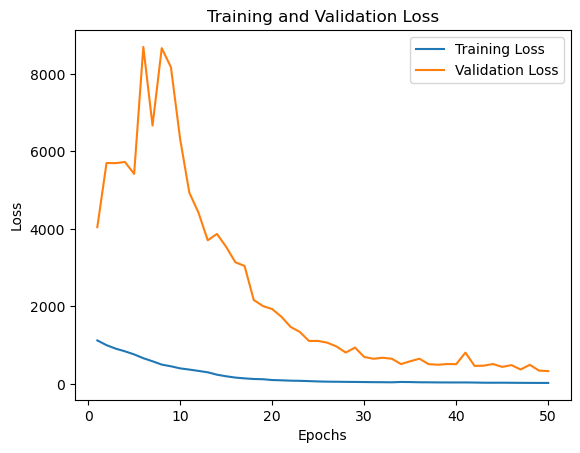

In [61]:
#Model Loss
train_loss = model_lstm.history['loss']
val_loss = model_lstm.history['val_loss']

epochs_lstm = range(1, len(train_loss) + 1)
plt.plot(epochs_lstm, train_loss, label='Training Loss')
plt.plot(epochs_lstm, val_loss, label='Validation Loss')
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc='best')
plt.show()

#### Model Predictions and Performance

In [64]:
#Predict y with test sets
y_pred = model.predict(X_test_lstm)

27/27 [==============================] - 0s 5ms/step


In [65]:
#Mean Absolute Error (MAE)
mae_metric = MeanAbsoluteError()

mae_metric.update_state(y_test_lstm, y_pred)
print("Model Prediction MAE: ", mae_metric.result().numpy())

#Root Mean Squared Error (RMSE)
rmse_metric = RootMeanSquaredError()

rmse_metric.update_state(y_test_lstm, y_pred)
print("Model Prediction RMSE: ", rmse_metric.result().numpy())

#R2 Score
r2_lstm = r2_score(y_test_lstm, y_pred)
print("R2 Score: ", r2_lstm)

Model Prediction MAE:  66.55543
Model Prediction RMSE:  100.32962
R2 Score:  -60.455582962680666


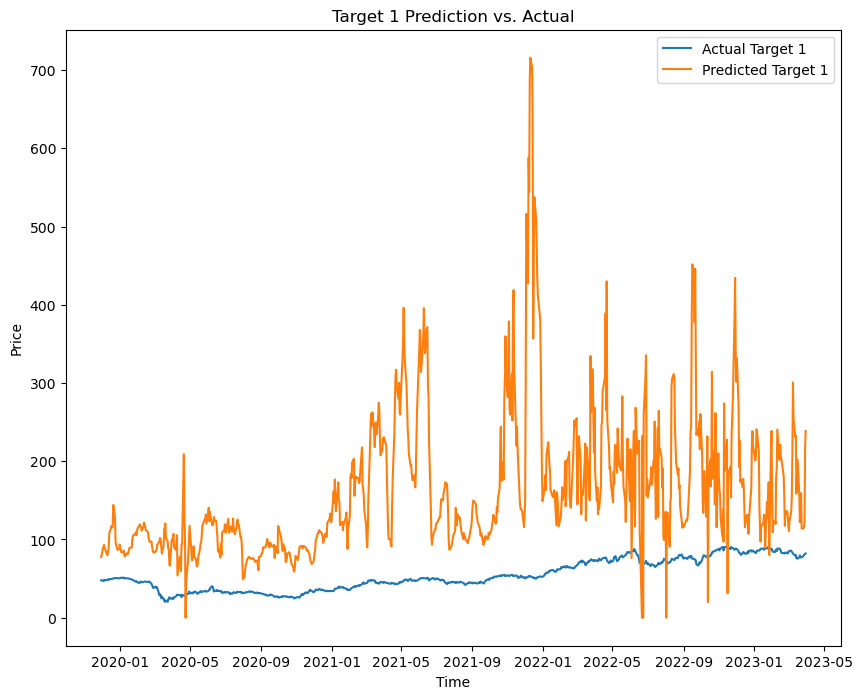

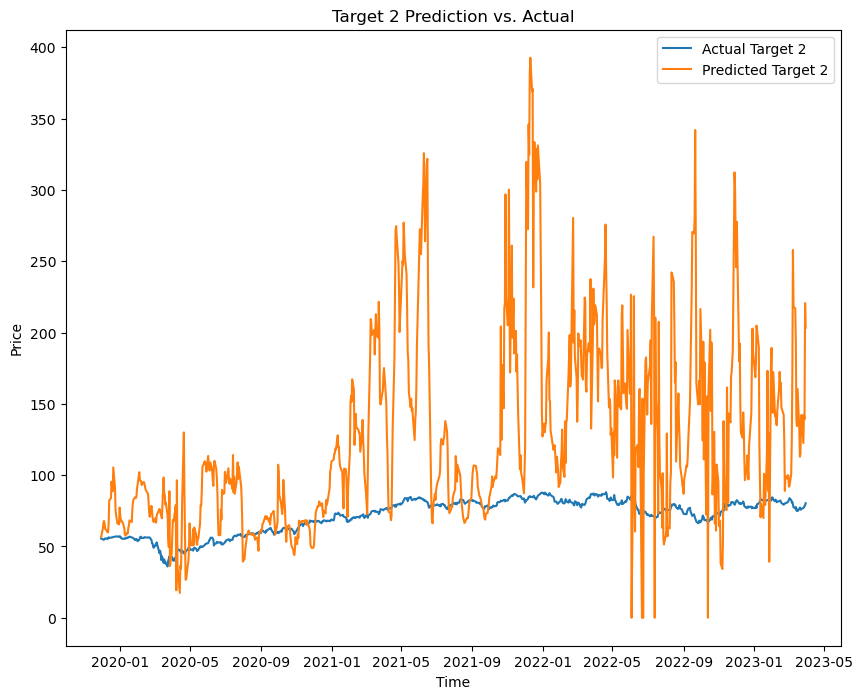

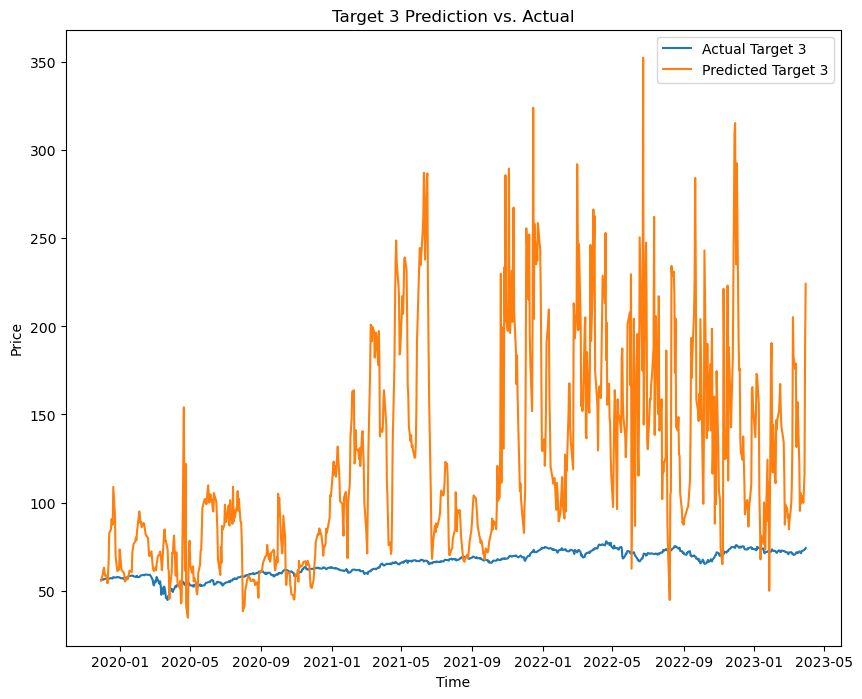

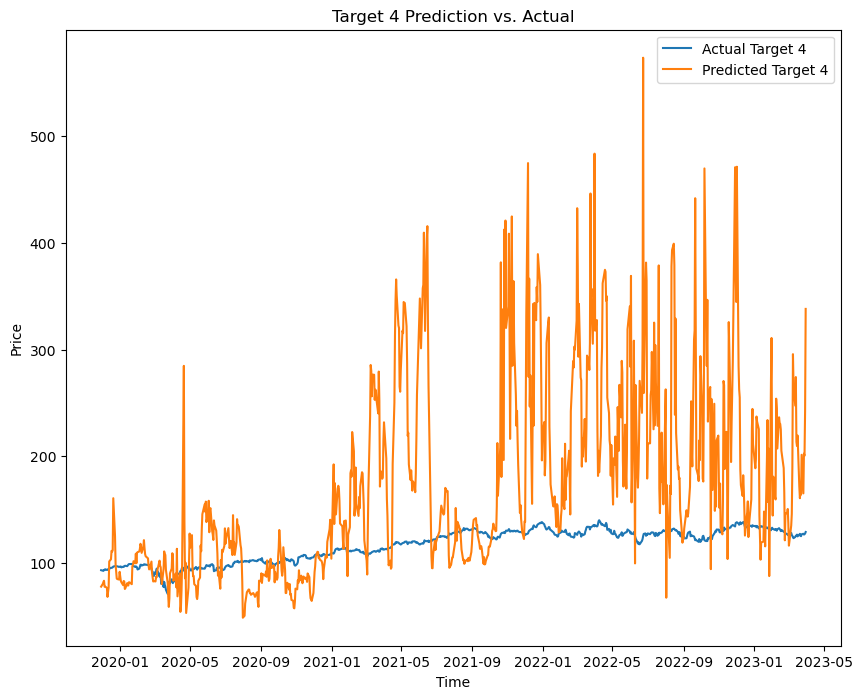

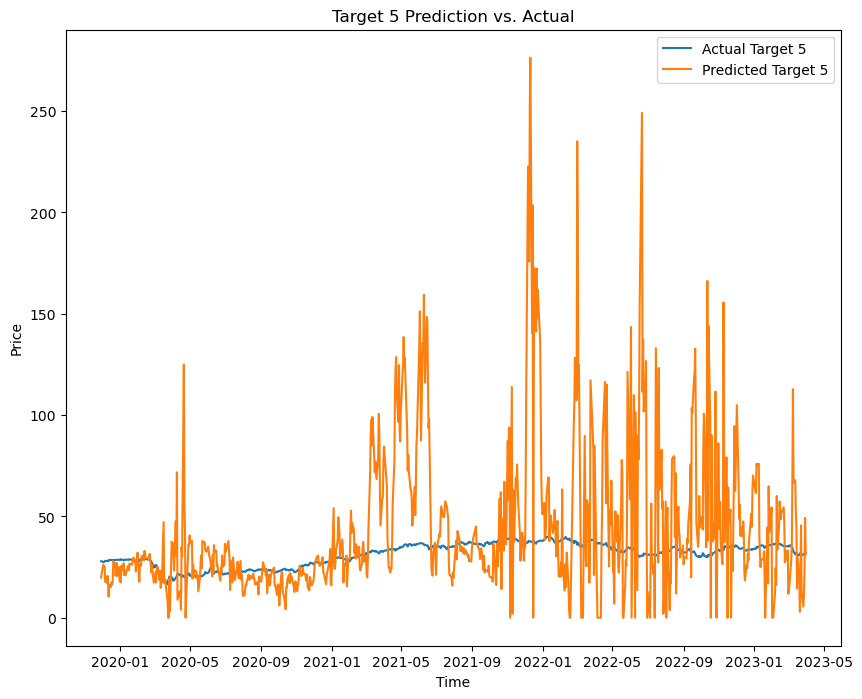

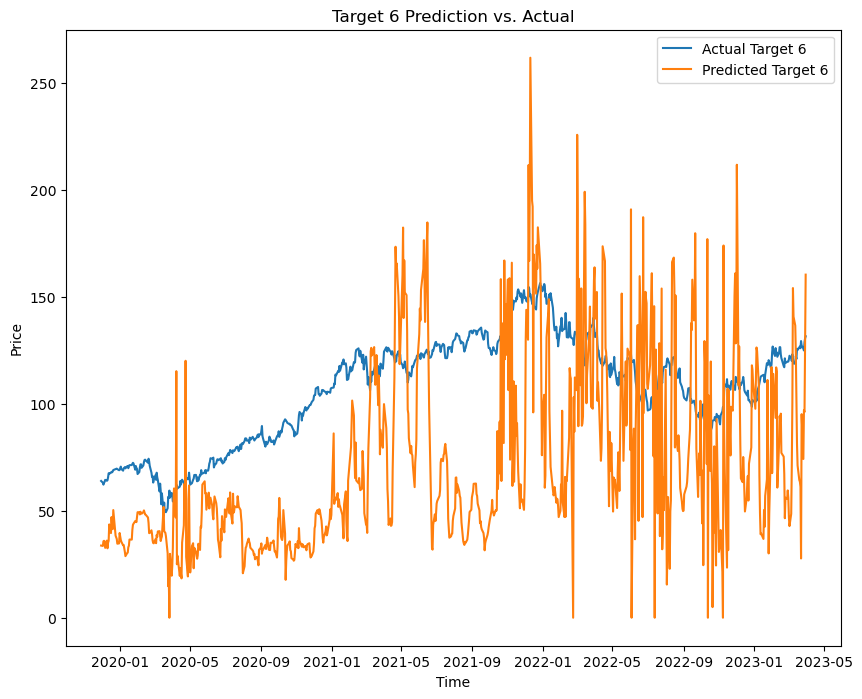

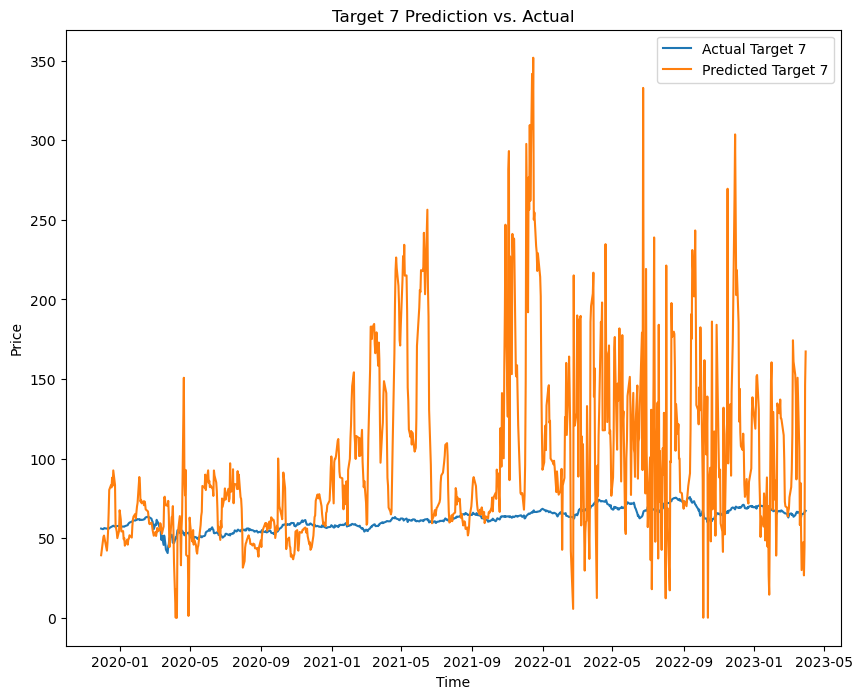

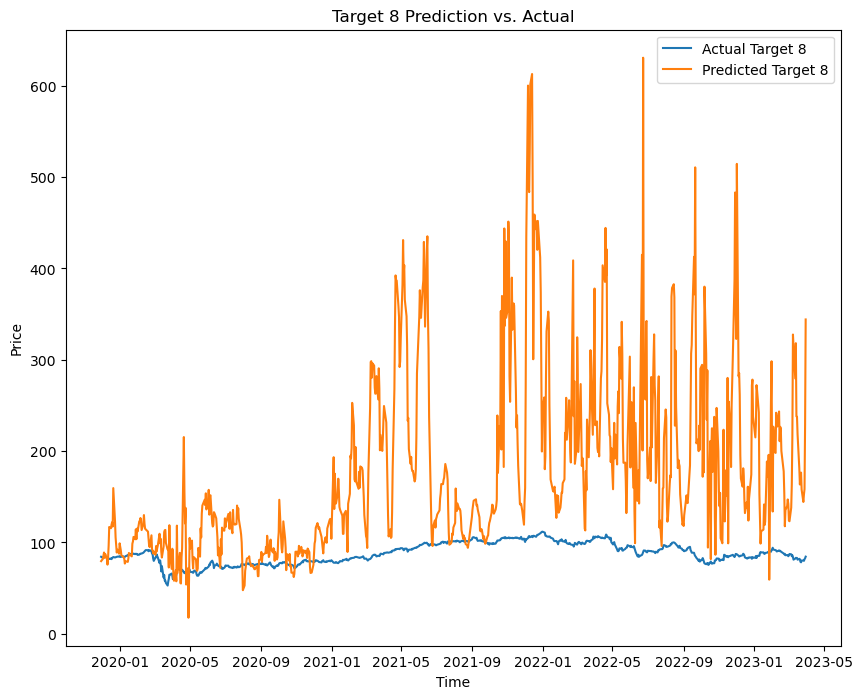

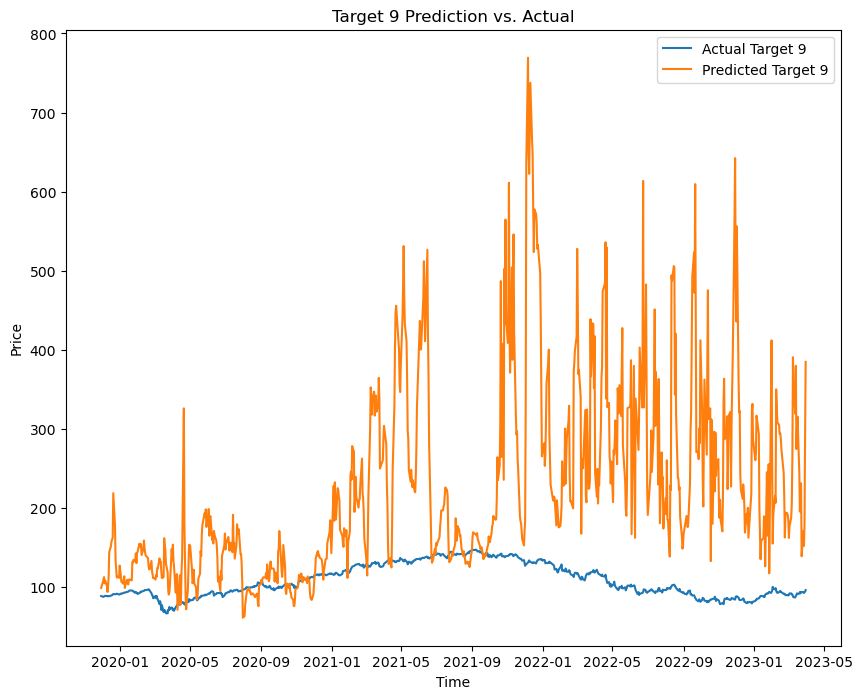

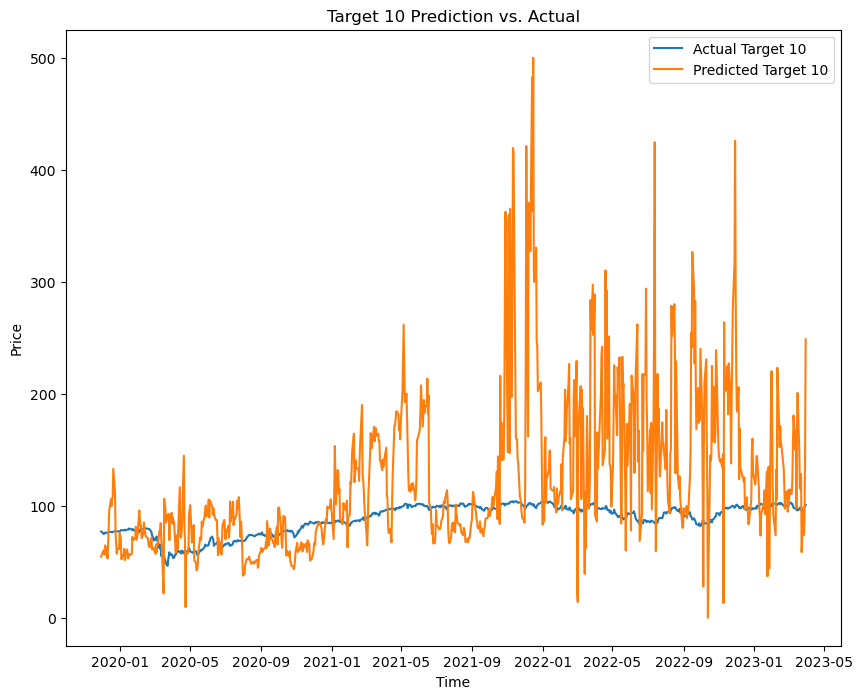

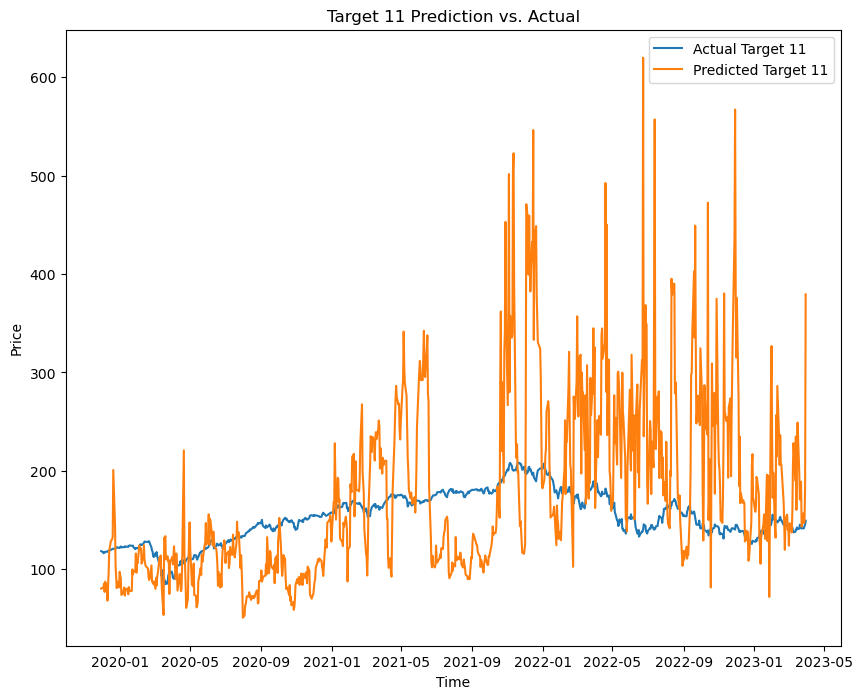

In [67]:
for i in range(y_pred.shape[1]):
    plt.figure(figsize=(10,8))
    plt.plot(y_test_lstm.index, y_test_lstm.iloc[:, i], label='Actual Target {}'.format(i+1))
    plt.plot(y_test_lstm.index, y_pred[:,i], label= 'Predicted Target {}'.format(i+1))
    plt.title('Target {} Prediction vs. Actual'.format(i+1))
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend(loc='best')

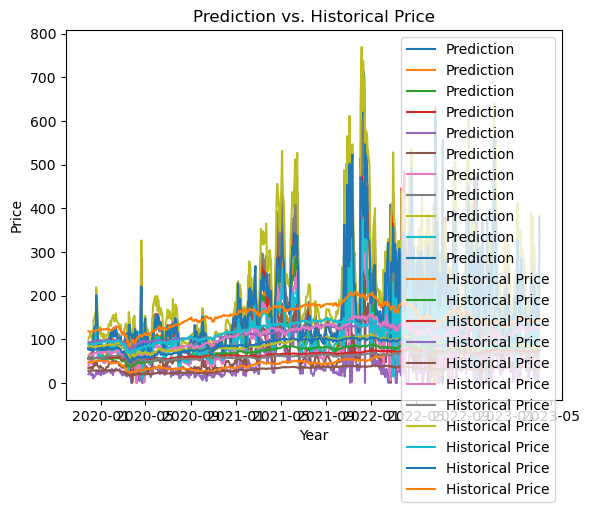

In [68]:
plt.plot(y_test_lstm.index, y_pred, label='Prediction')
plt.plot(y_test_lstm.index, y_test_lstm, label='Historical Price')
plt.title('Prediction vs. Historical Price')
plt.xlabel('Year')
plt.ylabel('Price')
plt.legend(loc='best')